In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [2]:
data = pd.read_csv('QueryResults_2.csv')

# Data preparation for text analysis

### Fonctions primaires 

In [4]:
def tokenizer_fct(question) :
    # print(sentence)
    question = BeautifulSoup(question).get_text()
    question = question.lower()
    #sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(question)
    return word_tokens


def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

### Fonction déstinée à la création d'un "Bag of Word"

In [5]:
def question_to_words_BW(question):
    # On récupère le texte
    question_text = BeautifulSoup(question).get_text()
    
    #On ne garde que les caractères intéressants. 
    question = re.sub("[^a-zA-Z+#]"," ", question_text)
    
    # On tokenize nos questions en mots.
    words = question.lower().split()
    
    # On retire les mots clés plus courants avec peu de valeur ajoutée. 
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
        
    # On lemmatize les mots
    meaningful_words = lemma_fct(meaningful_words)
    
    #On retourne une liste comprenant les mots ainsi récupérés. 
    return(" ".join( meaningful_words))

### Fonctions déstinée à la création du modèle Word2vec. 

In [6]:
def sentence_to_wordlist(sentence, remove_stopwords=False, remove_ponctuation=False,lemmatize = False):

    # 1. Remove HTML
    sentence = BeautifulSoup(sentence).get_text()
    sentence = re.sub("[^a-zA-Z+#]"," ", sentence)
    # 1. Tokenization des phrases en liste de mots. 
    words = sentence.split()    
    # 2. Lemmatisation des listes de mots(en option)
    if lemmatize:
        words = lemma_fct(words)
    
    # 3. Gestion des stopWords (en option)
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
        
    # 4. Gestion de la ponctuation (en option)
    if remove_ponctuation:
        ponct = ['[', ']', ',', '.', ':', '?', '(', ')','\'','\"','`']
        words = [w for w in words if not w in ponct]
    
    # 5. Return a list of words
    return(words)

In [7]:
def question_to_sentences(question, tokenizer):
    # Function to split a question into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    
    question = BeautifulSoup(question).get_text()
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(question.strip())
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(sentence_to_wordlist(raw_sentence, remove_stopwords=False,\
                                                  remove_ponctuation=False, lemmatize=False))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [8]:
#tokenizer qui décompose en phrases via la ponctuation= punkt
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

## Gestion des TAGS ( cible ) 

In [9]:
def tag_remover(tag):
    tag = tag.replace('>' , " ").replace('<', " ")
    return tag

def tag_to_word_list(tag):
    tag = BeautifulSoup(tag).get_text()
    tag = tag.split()
    return(tag)

In [10]:
Tags = []
for tag in data.Tags:
    tag = tag_remover(tag)
    tag = tag_to_word_list(tag)
    Tags.append(tag)
    
tag_bank = [] 
for tag in Tags : 
    for y in tag:
        tag_bank.append(y)

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


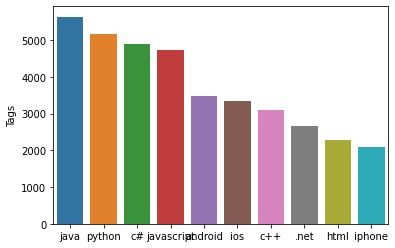

In [11]:
tags = pd.DataFrame()
tags['Tags'] = tag_bank
sns.barplot(tags['Tags'].value_counts().head(10).index,\
            tags['Tags'].value_counts().head(10))
top_ten = tags['Tags'].value_counts().head(10).index
top_ten_tags=[]
for i in range(len(top_ten)):
    top_ten_tags.append(top_ten[i])

In [12]:
tags['Tags'].value_counts().head(10).sum()

37339

In [13]:
#Création des data que nous utiliserons pour créer notre modèle supervisé
data_to_train = [] #--> X
target_to_train = [] #--> y
counter = 0
for tag in Tags:
    for i in tag:
        if i in top_ten_tags:            
            data_to_train.append(data.Body[counter])
            target_to_train.append(i)
            
            
    counter+=1

In [14]:
for tag in top_ten:
    print(tag)
    top_ten_tags.append(tag)

java
python
c#
javascript
android
ios
c++
.net
html
iphone


# BAG Of WORDS

### Préprocessing

In [15]:
questions_cleared = []
for question in data.Body:
        cleared_question = question_to_words_BW(question)
        questions_cleared.append(cleared_question)
        
# On créé le vectorizer qui va vectorizer les mots de nos questions. 
vectorizer = CountVectorizer(analyzer = "word", max_features = 5000) 
    
# On fit notre vectorizer avec nos questions. 
questions_features = vectorizer.fit_transform(questions_cleared)
#questions_features = questions_features.toarray()

### Modèle de prédiction

In [16]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20

lda = LatentDirichletAllocation(n_components = n_topics, max_iter = 5, learning_method='online',learning_offset=50.,random_state=0)

lda.fit(questions_features)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

In [17]:
lda.transform(questions_features[1])

array([[0.00142857, 0.00142857, 0.00142857, 0.00142857, 0.00142857,
        0.00142857, 0.37140788, 0.00142857, 0.00142857, 0.00142857,
        0.00142857, 0.36347772, 0.00142857, 0.00142857, 0.00142857,
        0.14473674, 0.00142857, 0.09752052, 0.00142857, 0.00142857]])

### Affichage des topics trouvés par notre modèle.


In [18]:
def display_topics(model, feature_names, no_top_words):
    topic_list = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        topic_list[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]

no_top_words = 5
display_topics(lda,vectorizer.get_feature_names(), 5)

Topic 0:
model build library project framework
Topic 1:
image import file data print
Topic 2:
user server request http client
Topic 3:
string name value list id
Topic 4:
table data database column query
Topic 5:
width height color td px
Topic 6:
error app code using work
Topic 7:
android java com layout org
Topic 8:
map size memory value byte
Topic 9:
test number testing option algorithm
Topic 10:
public class new void return
Topic 11:
one question use example case
Topic 12:
page http html url app
Topic 13:
div event form class button
Topic 14:
video stream frame cell angular
Topic 15:
would like way time use
Topic 16:
file command path local line
Topic 17:
function int array std return
Topic 18:
lib org python module package
Topic 19:
self view float nil def


/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
from __future__ import print_function
import pyLDAvis

import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, questions_features, vectorizer)

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documenta

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.195686 -0.087601       1        1  14.106683
11    -0.240866 -0.036800       2        1   9.409446
6     -0.075356 -0.159602       3        1   8.020085
10    -0.067414 -0.013278       4        1   7.365515
2      0.042814 -0.165012       5        1   7.141228
3     -0.129231  0.022906       6        1   6.726383
16     0.081682 -0.123112       7        1   5.270883
12     0.069972 -0.180230       8        1   4.552008
17    -0.160865  0.044238       9        1   4.400122
18     0.275073 -0.090994      10        1   4.217761
13     0.030559 -0.030268      11        1   4.188441
7      0.214641 -0.059298      12        1   4.086454
5     -0.041899  0.030574      13        1   3.695443
4     -0.035722  0.029650      14        1   3.376277
1      0.081258  0.091296      15        1   3.255828
0      0.056127 -0.047280      16        1   2.873944
19    -0.084184  0.127951      17        1   2.274423
8     -0.020819  0.289196      18        1   1.999787
9     -0.060996  0.122359      19        1   1.576078
14     0.260913  0.235303      20        1   1.463212, topic_info=          Term          Freq         Total Category  logprob  loglift
152    android  18529.000000  18529.000000  Default  30.0000  30.0000
1623      file  28794.000000  28794.000000  Default  29.0000  29.0000
2321      java  18626.000000  18626.000000  Default  28.0000  28.0000
4416      test  11668.000000  11668.000000  Default  27.0000  27.0000
1767  function  17755.000000  17755.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
3232      pipe    386.875278    575.206198  Topic20  -5.0154   3.8279
4189     start    670.542129   5738.241828  Topic20  -4.4654   2.0777
4168       src    503.321068   3776.283359  Topic20  -4.7523   2.2093
2649        mb    406.262644    961.787237  Topic20  -4.9665   3.3627
2182      init    434.221258   2776.246012  Topic20  -4.8999   2.3692

[1340 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         6  0.991622         aaa
5         6  0.986122         abc
5        12  0.011601         abc
8         1  0.552904        able
8         2  0.011532        able
...     ...       ...         ...
4985      8  0.997019     youtube
4985     12  0.002235     youtube
4989     14  0.995532          za
4995      1  0.986268   zookeeper
4999     12  0.997203  zygoteinit

[3961 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 12, 7, 11, 3, 4, 17, 13, 18, 19, 14, 8, 6, 5, 2, 1, 20, 9, 10, 15])

### Création de la Pipeline regroupant le préprocessing et le modèle LDA

In [16]:
# On créé le vectorizer qui va vectorizer les mots de nos questions. 

# Pour chaque question, on applique la fonction qui récupère les mots clés des questions posées. 
def clearing_questions(Body):
    # On créé une liste vide déstinée à receullir les mots de nos questions. 
    questions_cleared =[]
    for question in Body:
        cleared_question = question_to_words_BW(question)
        questions_cleared.append(cleared_question)
        
    return questions_cleared


In [17]:
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.experimental import enable_hist_gradient_boosting

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [19]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20

from sklearn.pipeline import Pipeline
transformer_1 = FunctionTransformer(clearing_questions)
pipeline = Pipeline([
   ('transformer', transformer_1), ('vectorizer',CountVectorizer(analyzer = "word", max_features = 5000)),
   ('LDA',LatentDirichletAllocation(n_components = n_topics, max_iter = 5,\
                                                                     learning_method='online',learning_offset=50.,random_state=0))
])

#### import joblib
joblib.dump(pipeline, 'pipeline_housing.joblib')
from mlflow.models.signature import infer_signature
signature = infer_signature(data.Body)
import mlflow
mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)

In [271]:
def tag_generator(questions):
    for question in questions:
        new_document_topic = np.where(question == question.max())
        new_document_topic = int(new_document_topic[0])
        print('La répartition des proba d\'appartenance aux différents TOPICS est \n  ', question)
        print('Les tags suggérés pour ce document sont :  \n',topic_list.T.iloc[new_document_topic,:5])

In [278]:
tag_generator(question_test)

La répartition des proba d'appartenance aux différents TOPICS est 
   [0.24166897 0.00092593 0.00092593 0.00092593 0.00092593 0.00092593
 0.47526279 0.00092593 0.00092593 0.00092593 0.2673275  0.00092593
 0.00092593 0.00092593 0.00092593 0.00092593 0.00092593 0.00092593
 0.00092593 0.00092593]
Les tags suggérés pour ce document sont :  
 0         use
1       would
2        like
3    question
4       using
Name: 6, dtype: object


# WORD2VEC Model

In [15]:
sentences = []
for question in data['Body']:
    sentences += (question_to_sentences(question,tokenizer))

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "https://stackoverflow.com/questions/66268/what-is-the-best-cc-coding-style-closed" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:337: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "https://lists.webkit.org/pipermail/webkit-dev/2008-September/005019.html
https://lists.webkit.org/pipermail/webkit-dev/2009-June/008182.html" looks like a URL. Be

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.uploadify.com/demos/
http://www.zamzar.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "https://cran.r-project.org/web/packages/gcbd/vignettes/gcbd.pdf." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://jsfiddle.net/RagKH/" looks like a URL. Beautiful Soup is not an HTTP c

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.outlinenone.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://github.com/MarkNijhof/Fohjin
http://cre8ivethought.com/blog/2009/11/12/cqrs--la-greg-young/
http://cre8ivethought.com/blog/2009/11/28/cqrs-trying-to-make-it-re-usable/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarn

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "https://github.com/parkwookyun/firebase-angular-board" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://en.cppreference.com/w/cpp/atomic/memory_order" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://jsfiddle.net/4wqEm/2/" looks like a URL. Beautiful Soup is not an HTTP client. You 

In [16]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 5      # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            vector_size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)



2022-04-15 17:28:15,164 : INFO : collecting all words and their counts
2022-04-15 17:28:15,164 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-15 17:28:15,191 : INFO : PROGRESS: at sentence #10000, processed 207221 words, keeping 15582 word types
2022-04-15 17:28:15,221 : INFO : PROGRESS: at sentence #20000, processed 425732 words, keeping 24491 word types
2022-04-15 17:28:15,252 : INFO : PROGRESS: at sentence #30000, processed 646514 words, keeping 31823 word types
2022-04-15 17:28:15,286 : INFO : PROGRESS: at sentence #40000, processed 865619 words, keeping 38257 word types
2022-04-15 17:28:15,320 : INFO : PROGRESS: at sentence #50000, processed 1082188 words, keeping 43565 word types
2022-04-15 17:28:15,354 : INFO : PROGRESS: at sentence #60000, processed 1323559 words, keeping 50362 word types
2022-04-15 17:28:15,390 : INFO : PROGRESS: at sentence #70000, processed 1559511 words, keeping 56463 word types


Training model...


2022-04-15 17:28:15,424 : INFO : PROGRESS: at sentence #80000, processed 1786222 words, keeping 61530 word types
2022-04-15 17:28:15,461 : INFO : PROGRESS: at sentence #90000, processed 2016835 words, keeping 66985 word types
2022-04-15 17:28:15,496 : INFO : PROGRESS: at sentence #100000, processed 2261480 words, keeping 72396 word types
2022-04-15 17:28:15,533 : INFO : PROGRESS: at sentence #110000, processed 2506493 words, keeping 78145 word types
2022-04-15 17:28:15,569 : INFO : PROGRESS: at sentence #120000, processed 2749958 words, keeping 83330 word types
2022-04-15 17:28:15,604 : INFO : PROGRESS: at sentence #130000, processed 2987200 words, keeping 88033 word types
2022-04-15 17:28:15,637 : INFO : PROGRESS: at sentence #140000, processed 3203252 words, keeping 91876 word types
2022-04-15 17:28:15,670 : INFO : PROGRESS: at sentence #150000, processed 3423062 words, keeping 95689 word types
2022-04-15 17:28:15,703 : INFO : PROGRESS: at sentence #160000, processed 3653806 words, k

2022-04-15 17:28:30,818 : INFO : EPOCH 4 - PROGRESS: at 83.50% examples, 1615789 words/s, in_qsize 9, out_qsize 0
2022-04-15 17:28:31,420 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-04-15 17:28:31,424 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-04-15 17:28:31,433 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-04-15 17:28:31,434 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-04-15 17:28:31,440 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-04-15 17:28:31,441 : INFO : EPOCH - 4 : training on 7482900 raw words (5890211 effective words) took 3.6s, 1619963 effective words/s
2022-04-15 17:28:32,451 : INFO : EPOCH 5 - PROGRESS: at 28.40% examples, 1604427 words/s, in_qsize 9, out_qsize 0
2022-04-15 17:28:33,452 : INFO : EPOCH 5 - PROGRESS: at 55.86% examples, 1618540 words/s, in_qsize 9, out_qsize 0
2022-04-15 17:28:34,457 : INFO : EPOCH 5 - PROGRESS: at 83.65% ex

## Embedding du modèle Word2Vec

In [28]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
    # 
    
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")

    # 
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
        if counter%1000. == 0.:
            print ("Review %d of %d" % (counter, len(reviews)))
       # 
       # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
       #
       # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [29]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. Notice that we now use stop word
# removal.

clean_train_questions = []
# Ici, data_to_train a été défini dans la partie "Gestion des Tags". Cela correspond aux données avec 
# au moins 1 des 10 tags les plus récurents. C'est sur ces données que l'on va entrainer notre modèle supervisé. 
for question in data_to_train:
    clean_train_questions.append(sentence_to_wordlist( question, \
        remove_stopwords=True ))
    
print ("Creating average feature vecs for test questions")
trainDataVecs = getAvgFeatureVecs(clean_train_questions, model, num_features)

Creating average feature vecs for test questions
Review 0 of 37339
Review 1000 of 37339
Review 2000 of 37339
Review 3000 of 37339
Review 4000 of 37339
Review 5000 of 37339
Review 6000 of 37339
Review 7000 of 37339
Review 8000 of 37339
Review 9000 of 37339
Review 10000 of 37339
Review 11000 of 37339
Review 12000 of 37339
Review 13000 of 37339
Review 14000 of 37339
Review 15000 of 37339
Review 16000 of 37339
Review 17000 of 37339
Review 18000 of 37339
Review 19000 of 37339
Review 20000 of 37339
Review 21000 of 37339
Review 22000 of 37339
Review 23000 of 37339
Review 24000 of 37339
Review 25000 of 37339
Review 26000 of 37339
Review 27000 of 37339
Review 28000 of 37339
Review 29000 of 37339
Review 30000 of 37339
Review 31000 of 37339
Review 32000 of 37339
Review 33000 of 37339
Review 34000 of 37339
Review 35000 of 37339
Review 36000 of 37339
Review 37000 of 37339


In [30]:
X_train, X_test, y_train, y_test = train_test_split(trainDataVecs,target_to_train_encoded,test_size=0.3)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

model_to_set = OneVsRestClassifier(SVC(kernel="poly"))

parameters = {
    "estimator__C": [1,2,4,8],
    "estimator__kernel": ["poly","rbf"],
    "estimator__degree":[1, 2, 3, 4],
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters,scoring=f1_score)

model_tunning.fit(X_train, y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)
print(model_tunning.cv_results_)

/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: f1_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/florentmargery/opt/anaconda3/envs/work_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(e

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

#Avec Probas :
#clf = OneVsRestClassifier(SVC(probability=True)).fit(X_train, y_train)

#Sans Probas : 
clf = OneVsRestClassifier(SVC(probability=False)).fit(X_train, y_train)

In [ ]:
clf.score(X_train,y_train)

In [ ]:
clf.score(X_test,y_test)

### Pipeline

### Créons une pipeline afin de faciliter la prédiction de notre notre modèle. 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
target_to_train_encoded = label_encoder.fit_transform(target_to_train)

X_train, X_test, y_train, y_test = train_test_split(data_to_train,target_to_train_encoded,test_size=0.3)

In [26]:
len(target_to_train_encoded)

37339

In [21]:
def cleaning_question_W2V(data_to_train):
    
    clean_train_questions = []
    # Ici, data_to_train a été défini dans la partie "Gestion des Tags". Cela correspond aux données avec 
    # au moins 1 des 10 tags les plus récurents. C'est sur ces données que l'on va entrainer notre modèle supervisé. 
    for question in data_to_train:
        clean_train_questions.append(sentence_to_wordlist( question, \
            remove_stopwords=True ))
    
    print ("Creating average feature vecs for test questions")
    trainDataVecs = getAvgFeatureVecs(clean_train_questions, model, num_features)
    return trainDataVecs

# Création d'un transformeur, permettant d'intégrer notre fonction dans la pipeline. 

from sklearn.preprocessing import FunctionTransformer
transformer_2 = FunctionTransformer(cleaning_question_W2V)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

### Création de la pipeline 

In [24]:
pipeline = Pipeline([
   ('transformer', transformer_2), ('clf',OneVsRestClassifier(SVC(probability=False))), 
])

In [27]:
pipeline.fit(X_train, y_train)

Creating average feature vecs for test questions
Review 0 of 26137
Review 1000 of 26137
Review 2000 of 26137
Review 3000 of 26137
Review 4000 of 26137
Review 5000 of 26137
Review 6000 of 26137
Review 7000 of 26137
Review 8000 of 26137
Review 9000 of 26137
Review 10000 of 26137
Review 11000 of 26137
Review 12000 of 26137
Review 13000 of 26137
Review 14000 of 26137
Review 15000 of 26137
Review 16000 of 26137
Review 17000 of 26137
Review 18000 of 26137
Review 19000 of 26137
Review 20000 of 26137
Review 21000 of 26137
Review 22000 of 26137
Review 23000 of 26137
Review 24000 of 26137
Review 25000 of 26137
Review 26000 of 26137


Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<function cleaning_question_W2V at 0x7fbe5d0de5e0>)),
                ('clf', OneVsRestClassifier(estimator=SVC()))])

### Prédiction du OVA

In [ ]:
clean_test_questions = []
data_to_test = data.Body[12356:12359]
for question in data_to_test:
    clean_test_questions.append(sentence_to_wordlist( question, \
        remove_stopwords=True ))
    
print ("Creating average feature vecs for test questions")
testDataVecs = getAvgFeatureVecs(clean_test_questions, model, num_features)

prediction = clf.predict(testDataVecs)
prediction = label_encoder.inverse_transform(prediction)
proba = clf.predict_proba(testDataVecs)
for i in range(len(prediction)):
    print('le texte n°',i,'est : \n', BeautifulSoup(data_to_test.iloc[i]).get_text() )
    print('LA PREDICTION EST :' , prediction[i])
    print('VECTEUR DE PROBA', proba[i])

### Optional : Clustering

In [ ]:
from sklearn.cluster import KMeans
import time

start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.vectors
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for K Means clustering: ", elapsed, "seconds.")

# API

In [86]:
from fast_dash import FastDash
from fast_dash.Components import Text

# Step 1: Define your model inference
def text_to_text_function(question):
    result = pipeline.predict([question])
    result = label_encoder.inverse_transform(result)[0]
    return result

# Step 2: Specify the input and output components
app = FastDash(callback_fn=text_to_text_function, 
                inputs=Text, 
                outputs=Text, 
                title='App title')

# Step 3: Run your app!
app.run()

# * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)

 * Serving Flask app 'fast_dash.fast_dash' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


2022-04-14 21:54:59,694 : INFO :  * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)
2022-04-14 21:55:05,531 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:05] "GET / HTTP/1.1" 200 -
2022-04-14 21:55:05,560 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:05] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_3_1m1649961764.12.1.min.js HTTP/1.1" 200 -
2022-04-14 21:55:05,563 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:05] "GET /_dash-component-suites/dash/deps/react@16.v2_3_1m1649961764.14.0.min.js HTTP/1.1" 200 -
2022-04-14 21:55:05,568 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:05] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_3_1m1649961764.14.0.min.js HTTP/1.1" 200 -
2022-04-14 21:55:05,570 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:05] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_3_1m1649961764.7.2.min.js HTTP/1.1" 200 -
2022-04-14 21:55:05,574 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:05] "GET /_dash-component-suites/dash/dcc/dash_core_components.v2_3_0m1649961764.js

2022-04-14 21:55:19,780 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:19] "POST /_dash-update-component HTTP/1.1" 200 -
2022-04-14 21:55:19,860 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:19] "POST /_dash-update-component HTTP/1.1" 200 -
2022-04-14 21:55:19,932 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:19] "POST /_dash-update-component HTTP/1.1" 200 -
2022-04-14 21:55:20,030 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:20] "POST /_dash-update-component HTTP/1.1" 200 -
2022-04-14 21:55:20,262 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:20] "POST /_dash-update-component HTTP/1.1" 200 -
2022-04-14 21:55:20,357 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:20] "POST /_dash-update-component HTTP/1.1" 200 -
2022-04-14 21:55:20,504 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:20] "POST /_dash-update-component HTTP/1.1" 200 -
2022-04-14 21:55:20,618 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:20] "POST /_dash-update-component HTTP/1.1" 200 -
2022-04-14 21:55:20,689 : INFO : 127.0.0.1 - - [14/Apr/2022 21:55:20] "P

Creating average feature vecs for test questions
Review 0 of 1
